# Loan Approval Classification - XGBClassifier auto-tuning

## Download Dataset

In [29]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("taweilo/loan-approval-classification-data")

print("Path to dataset files:", path)

100%|█████████████████████████████████████████████████████████████████████████████████| 751k/751k [00:00<00:00, 874kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/taweilo/loan-approval-classification-data/versions/1


## Import Dependencies

In [30]:
import pandas as pd
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from xgbtune import tune_xgb_model
from sklearn.preprocessing import LabelEncoder

## Read Dataset

In [31]:
df = pd.read_csv(path + "/loan_data.csv")

In [32]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


## Correlation Analysis

In [38]:
df_oi = df.copy()

columns_to_encode = ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']

encoder = LabelEncoder()

for column in columns_to_encode:
    df_oi[column] = encoder.fit_transform(df_oi[column])
    
df_oi.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,0,4,71948.0,0,3,35000.0,4,16.02,0.49,3.0,561,0,1
1,21.0,0,3,12282.0,0,2,1000.0,1,11.14,0.08,2.0,504,1,0
2,25.0,0,3,12438.0,3,0,5500.0,3,12.87,0.44,3.0,635,0,1
3,23.0,0,1,79753.0,0,3,35000.0,3,15.23,0.44,2.0,675,0,1
4,24.0,1,4,66135.0,1,3,35000.0,3,14.27,0.53,4.0,586,0,1


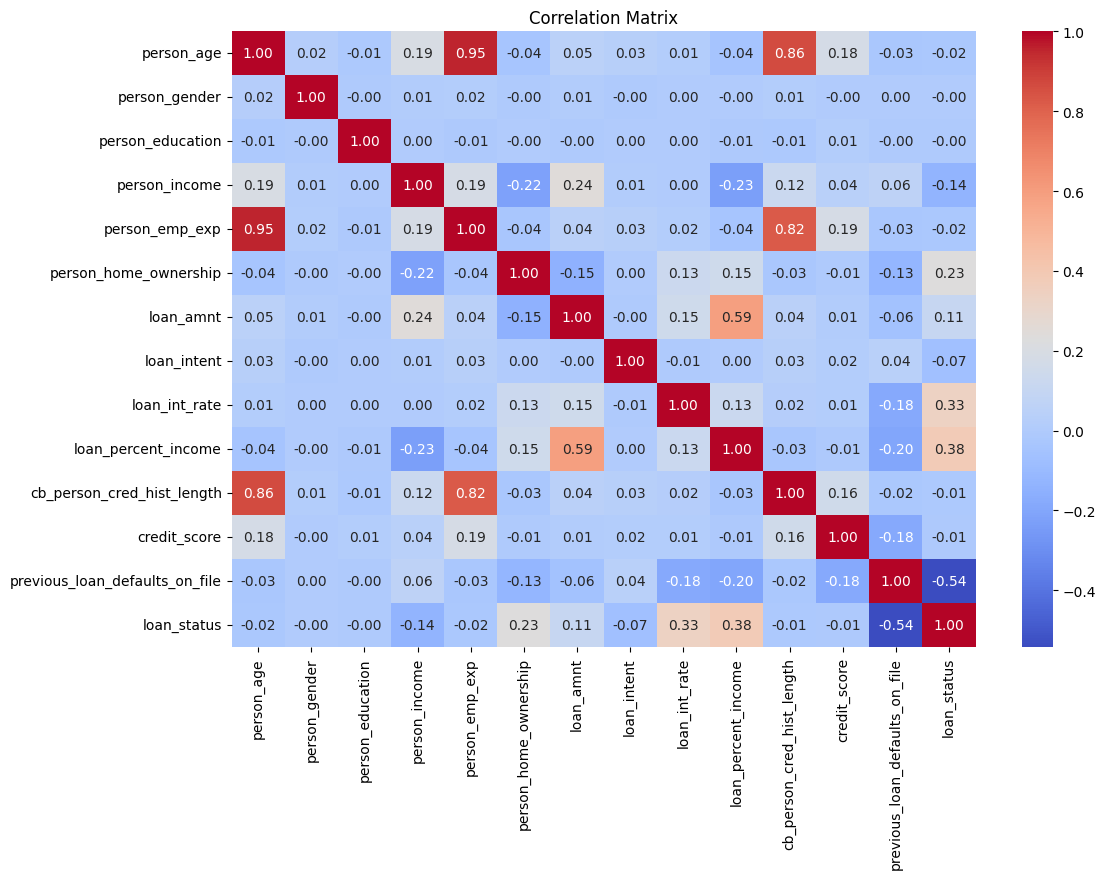

In [39]:


correlation = df_oi.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Model and tuning

In [50]:
# Prepare the data
X = df_oi.drop(columns=['loan_status'])
y = df_oi['loan_status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.3, random_state=42)



# Define the parameter grid for tuning
param_grid = {
    'eval_metric': 'error',
    'objective': 'binary:logistic',
}

params, round_count = tune_xgb_model(param_grid, X_train, y_train, X_val, y_val)

# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(**params)


tuning pass 0...
computing best round...
best round: 27
tuning max_depth and min_child_weight ...
best loss: 0.07296296296296297
best max_depth: 7
best min_child_weight: 1
tuning gamma ...
best loss: 0.07296296296296297
best gamma: 0.0
re-computing best round...
best round: 21
tuning subsample and colsample_bytree ...
best loss: 0.0725925925925926
best subsample: 0.7
best colsample_bytree: 0.7
fine tuning subsample and colsample_bytree ...
best loss: 0.0725925925925926
best subsample: 0.7
best colsample_bytree: 0.7
tuning alpha and lambda ...
best loss: 0.0725925925925926
best alpha: 0
best lambda: 1
tuning seed ...
best loss: 0.0725925925925926
best seed: 0
{'eval_metric': 'error', 'objective': 'binary:logistic', 'max_depth': 7, 'min_child_weight': 1, 'gamma': 0.0, 'subsample': 0.7, 'colsample_bytree': 0.7, 'alpha': 0, 'lambda': 1, 'seed': 0}
tuning pass 1...
computing best round...
best round: 36
tuning max_depth and min_child_weight ...
best loss: 0.07074074074074074
best max_depth:

### Making predictions

In [51]:
# Fit the model
xgb_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_clf.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      4879
           1       0.89      0.80      0.84      1421

    accuracy                           0.93      6300
   macro avg       0.91      0.88      0.90      6300
weighted avg       0.93      0.93      0.93      6300



## Plot predictions versus test

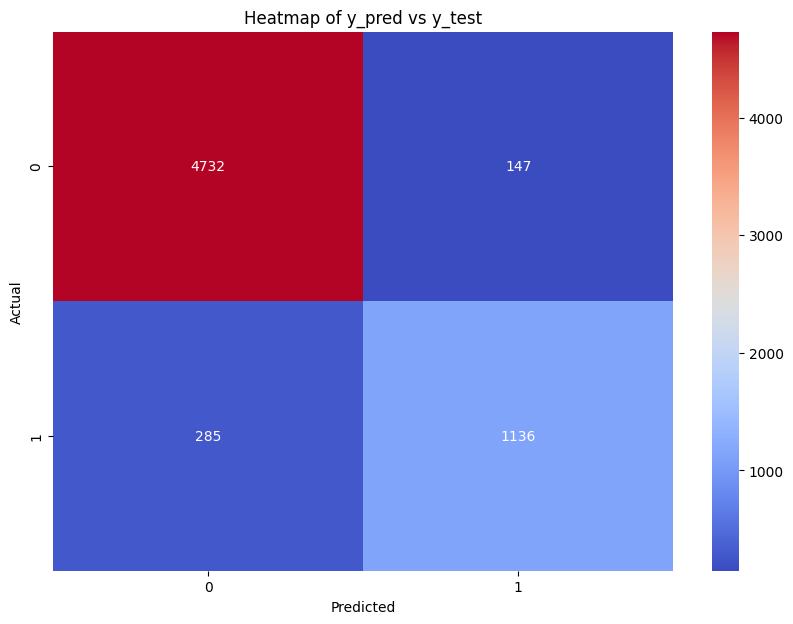

In [52]:
# Create a DataFrame with y_test and y_pred
results_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})

# Create a confusion matrix
confusion_matrix = pd.crosstab(results_df['y_test'], results_df['y_pred'], rownames=['Actual'], colnames=['Predicted'])

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='coolwarm')
plt.title('Heatmap of y_pred vs y_test')
plt.show()